In [1]:
import os
import itertools
import matplotlib as mpl


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


width, height = set_size(252, fraction=1.0)
widht = 2 * width

# width = 5
# height = width/1.618
fontsize = 9

mpl.rcParams.update(
    {
        "font.size": fontsize,
        "figure.figsize": (width, height),
        "figure.facecolor": "white",
        "savefig.dpi": 360,
        "figure.subplot.bottom": 0.125,
        "figure.edgecolor": "white",
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
    }
)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from deephyper.skopt.moo import pareto_front, non_dominated_set, hypervolume
from deephyper.skopt.utils import cook_objective_scaler
from deephyper.analysis import rank

In [2]:
# task_name = "navalpropulsion"
# task_name = "parkinsonstelemonitoring"
# task_name = "proteinstructure"
# task_name = "slicelocalization"

tasks = ["navalpropulsion", "parkinsonstelemonitoring", "proteinstructure", "slicelocalization"]
# tasks = ["navalpropulsion", "parkinsonstelemonitoring"] 
objective_columns = ["objective_0", "objective_1"]
n_objectives = 2
scalers = ["identity", "minmaxlog", "quantile-uniform"]
strategies = ["Linear", "Chebyshev", "PBI"]
repetitions = list(range(10))
# repetitions = list(range(5))

In [3]:
def load_data_from_task(task_name):
    """
        New colums are:
        - strategy: the name of the strategy.
        - scaler: the name of the scaler.
        - task: the name of the task.
    """

    df_results = []

    for scaler, strategy in itertools.product(scalers, strategies):

        for i in repetitions:
            path = f"output/hpobench/{task_name}/{i}/{strategy.lower()}-{scaler}/results.csv"

            if not(os.path.exists(path)):
                print(f"Skipping: {path} because not found.")
                continue

            df = pd.read_csv(path)
            
            if len(df) < 200:
                print(f"Skipping: {path} because imcomplete.")
                continue

            df["repetition"] = i
            df["strategy"] = f"{strategy}"
            df["scaler"] = scaler
            df_results.append(df)

    other_results = ["random", "nsgaii", "tpe", "smac", "botorch"]
    for label in other_results:

        for i in repetitions:
            path = f"output/hpobench/{task_name}/{i}/{label}/results.csv"

            if not(os.path.exists(path)):
                print(f"Skipping: {path}")
                continue

            df = pd.read_csv(path)

            if len(df) < 200:
                print(f"Skipping: {path} because imcomplete.")
                continue
            
            df["repetition"] = i
            df["strategy"] = label
            df["scaler"] = "identity"
            df_results.append(df)

    df = pd.concat(df_results, ignore_index=True)
    df.drop(columns=["Unnamed: 0"], inplace=True)
    df["task"] = task_name

    return df

## Check Objective Scaling

Id


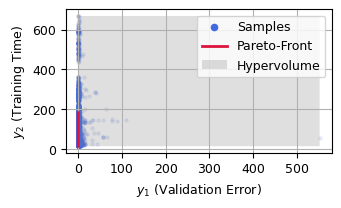

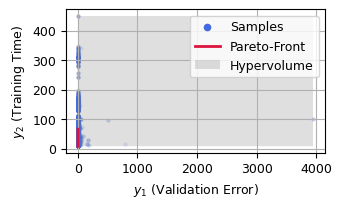

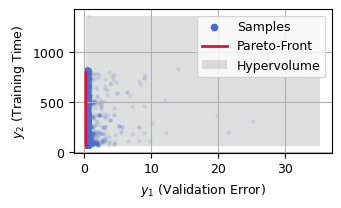

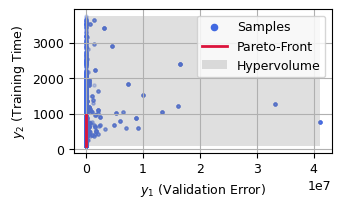

MML


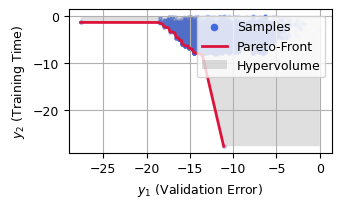

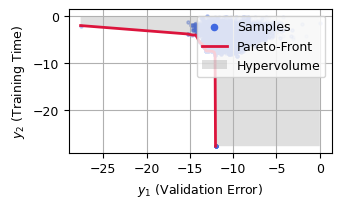

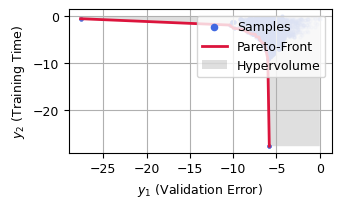

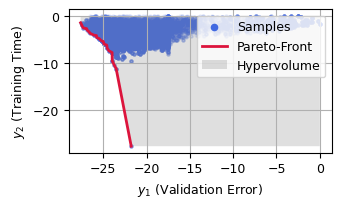

QU


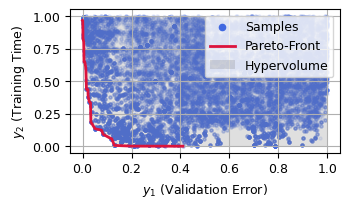

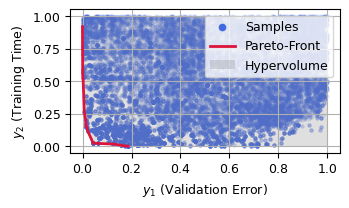

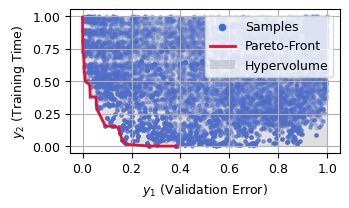

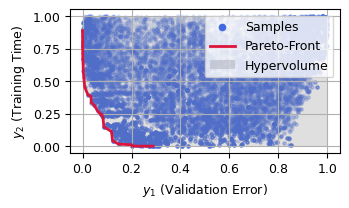

In [4]:
scalers = {"identity": "Id", "minmaxlog": "MML", "quantile-uniform": "QU"}

for scaler_key, scaler_label in scalers.items():
    
    print(scaler_label)

    # Load data
    df = pd.concat(
        [load_data_from_task(task_name) for task_name in tasks], ignore_index=True
    )

    # Scale data
    scaler = cook_objective_scaler(scaler_key, None)
    for (task_name,), group_df in df.groupby(["task"]):
        df.loc[group_df.index, objective_columns] = scaler.fit_transform(
            -group_df[objective_columns].values
        )

    for (task_name,), group_df in df.groupby(["task"]):
        objectives = group_df[objective_columns].values
        pf = pareto_front(objectives, sort=True)
        ref = np.max(objectives, axis=0)
        hv_x = pf[:, 0].tolist()
        hv_y = pf[:, 1].tolist()
        hv_x = [ref[0]] + [hv_x[0]] + hv_x + [ref[0]] + [ref[0]]
        hv_y = [ref[1]] + [ref[1]] + hv_y + [hv_y[-1]] + [ref[1]]
        plt.figure() 
        plt.scatter(objectives[:,0], objectives[:, 1], color="royalblue", s=5, alpha=0.1, label="Samples")
        plt.plot(pf[:,0], pf[:, 1], color="crimson", linewidth=2, label="Pareto-Front")
        plt.fill(hv_x, hv_y, facecolor="gray", edgecolor="none", alpha=0.25, linewidth=2, label="Hypervolume")
        plt.xlabel(r"$y_1$ (Validation Error)")
        plt.ylabel(r"$y_2$ (Training Time)")

        # handles, labels =  plt.gca().get_legend_handles_labels()
        # handle_scatter = mpatches.Patch(color=handles[0].get_facecolor(), label=handles[0].get_label())
        # handles[0] = handle_scatter

        legend = plt.legend(loc="upper right")
        legend.legend_handles[0].set_sizes([20])
        legend.legend_handles[0].set_alpha(1)

        plt.grid()
        plt.tight_layout()
        plt.savefig(f"output/hpobench/figures/scaler_{scaler_key}_{task_name}.png", dpi=300)
        plt.show() 

    # break

## Check Ranking & Average

In [5]:
# Scale objectives to be uniformly distributed in [0, 1]

# Load data
df = pd.concat(
    [load_data_from_task(task_name) for task_name in tasks], ignore_index=True
)

scaler = cook_objective_scaler("quantile-uniform", None)
for (task_name,), group_df in df.groupby(["task"]):
    df.loc[group_df.index, objective_columns] = scaler.fit_transform(-group_df[objective_columns].values)

In [6]:
def hypervolume_curve(y, ref_point):
    assert np.shape(y)[1] == np.shape(ref_point)[0]

    hv = []
    for i in range(len(y)):
        pf = pareto_front(y[: i + 1])
        hv.append(hypervolume(pf, ref=ref_point))
    return hv

In [7]:
# Compute the hypervolume curve
df["hypervolume"] = None
for group_values, group_df in tqdm(df.groupby(["task", "strategy", "scaler", "repetition"])):
    hv = hypervolume_curve(group_df[objective_columns].values, ref_point=[1.0 for _ in range(n_objectives)])
    df.loc[group_df.index, "hypervolume"] = hv

  0%|          | 0/560 [00:00<?, ?it/s]

In [23]:
scaler_linestyle = {
    "identity": "-",
    "minmaxlog": ":",
    "quantile-uniform": "--",
    "log": (5, (10, 3)),
}

strategy_color = {
    "Linear": "seagreen",
    "Chebyshev": "orange",
    "PBI": "royalblue",
    "Linear_mf": "lime",
    "Chebyshev_mf": "yellow",
    "PBI_mf": "cyan",
    "nsgaii": "crimson",
    "random": "black",
    "tpe": "pink",
    "smac": "cyan",
    "botorch": "lime",
    
}

label_mapping = {
    "Linear": "L",
    "Chebyshev": "CH",
    "PBI": "PBI",
    "nsgaii": "NSGAII (Optuna)",
    "random": "Random",
    "tpe": "MoTPE (Optuna)",
    "smac": "ParEGO (SMAC)",
    "botorch": "qEHVI (BoTorch)",
    "identity": "Id",
    "minmaxlog": "MML",
    "quantile-uniform": "QU",
}

['Linear-quantile-uniform', 'botorch-identity', 'nsgaii-identity', 'random-identity', 'smac-identity', 'tpe-identity']
['Linear-quantile-uniform', 'botorch-identity', 'nsgaii-identity', 'random-identity', 'smac-identity', 'tpe-identity']
['Linear-quantile-uniform', 'botorch-identity', 'nsgaii-identity', 'random-identity', 'smac-identity', 'tpe-identity']
['Linear-quantile-uniform', 'botorch-identity', 'nsgaii-identity', 'random-identity', 'smac-identity', 'tpe-identity']
['Linear-quantile-uniform', 'botorch-identity', 'nsgaii-identity', 'random-identity', 'smac-identity', 'tpe-identity']
['Linear-quantile-uniform', 'botorch-identity', 'nsgaii-identity', 'random-identity', 'smac-identity', 'tpe-identity']
['Linear-quantile-uniform', 'botorch-identity', 'nsgaii-identity', 'random-identity', 'smac-identity', 'tpe-identity']
['Linear-quantile-uniform', 'botorch-identity', 'nsgaii-identity', 'random-identity', 'smac-identity', 'tpe-identity']
['Linear-quantile-uniform', 'botorch-identity', 

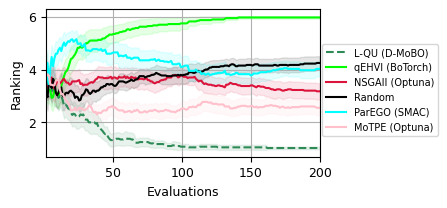

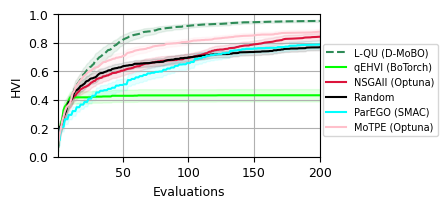

In [25]:
# scaler = "quantile-uniform"
# scaler = "minmaxlog"
# scaler = "identity"
# scaler = "log"
# scaler = "minmax"

# bbox_to_anchor = (1.21, 1.025)
bbox_to_anchor = (1.28, 0.8)
postfix = "_algorithms"

# filter = ((df["task"] == "navalpropulsion") & (df["scaler"] == scaler)) | (df["strategy"].isin(["random", "nsgaii"]))
# filter = df["task"] == "navalpropulsion"

# filter = (df["task"] == "navalpropulsion") & (
# filter = (df["task"] == "parkinsonstelemonitoring") & (
# filter = (df["task"] == "proteinstructure") & (
# filter = (df["task"] == "slicelocalization") & (
filter = (
    # (df["scaler"] == scaler) | (df["strategy"].isin(["random", "nsgaii"]))
    (
        # df["scaler"].isin(["identity", "minmaxlog", "quantile-uniform"])
        # & df["strategy"].isin(["Linear", "Chebyshev", "PBI"])
        df["scaler"].isin(["quantile-uniform"])
        & df["strategy"].isin(["Linear"])
    )
    | df["strategy"].isin(["random", "nsgaii", "botorch", "smac", "tpe"])
    # ((df["strategy"] == "Chebyshev") & (df["scaler"].isin(["quantile-uniform"]))) | (df["strategy"].isin(["random", "nsgaii"]))
    # (df["scaler"].isin(["minmax", "quantile-uniform"])) | (df["strategy"].isin(["random", "nsgaii"]))
)

task_rankings = []
task_scores = []
for labels, group_df in df[filter].groupby(["task", "repetition"]):
    group_labels = []
    group_hv = []
    for gv, gdf in group_df.groupby(["strategy", "scaler"]):
        group_labels.append("-".join(gv))
        group_hv.append(gdf["hypervolume"].values)
    print(group_labels)

    group_hv = np.array(group_hv)

    # Simple ranking which does not take into account ties given a tolerance
    # ranks = group_hv.shape[0] - np.argsort(group_hv, axis=0)

    # Ranking which takes into account ties given a tolerance
    ranks = np.zeros_like(group_hv).astype(int)
    for i in range(group_hv.shape[1]):
        r = group_hv.shape[0] - rank(group_hv[:, i], decimals=5) + 1
        ranks[:, i] = r

    task_scores.append(group_hv)
    task_rankings.append(ranks)

task_rankings = np.array(task_rankings).astype(float)
task_scores = np.array(task_scores).astype(float)

print(f"{task_rankings.shape=}")
print(f"{task_scores.shape=}")

conf = 1.96
n = task_rankings.shape[0]

average_rankings = np.mean(task_rankings, axis=0)
stde_rankings = conf * np.std(task_rankings, axis=0) / np.sqrt(n)

average_scores = np.mean(task_scores, axis=0)
stde_scores = conf * np.std(task_scores, axis=0) / np.sqrt(n)

fig = plt.figure()
for i, label in enumerate(group_labels):
    flabel = label
    if (
        "nsgaii" in label
        or "random" in label
        or "tpe" in label
        or "smac" in label
        or "botorch" in label
    ):
        flabel = flabel.replace(
            flabel.split("-")[0], label_mapping[flabel.split("-")[0]]
        )
        flabel = flabel.split("-")[0]
    else:
        flabel = flabel.replace(
            flabel.split("-")[0],
            label_mapping.get(flabel.split("-")[0], flabel.split("-")[0]),
        )
        flabel = flabel.replace(
            flabel[flabel.index("-") + 1 :],
            label_mapping[flabel[flabel.index("-") + 1 :]],
        )
        if flabel == "L-QU":
            flabel = "L-QU (D-MoBO)"

    x = np.arange(len(average_rankings[i])) + 1
    plt.plot(
        x,
        average_rankings[i],
        linestyle=scaler_linestyle.get("-".join(label.split("-")[1:]), "-"),
        color=strategy_color.get(label.split("-")[0]),
        label=flabel,
    )
    plt.fill_between(
        x,
        average_rankings[i] - stde_rankings[i],
        average_rankings[i] + stde_rankings[i],
        alpha=0.1,
        color=strategy_color.get(label.split("-")[0]),
    )
plt.xlabel("Evaluations")
plt.ylabel("Ranking")
# fig.legend(ncols=3, bbox_to_anchor=(0.92, 1.3), fontsize=7)
# fig.legend(ncols=2, bbox_to_anchor=(1.45, 0.8), fontsize=7)
fig.legend(ncols=1, bbox_to_anchor=bbox_to_anchor, fontsize=7)
plt.grid()
plt.xlim(1, average_rankings.shape[1])
plt.tight_layout()
plt.savefig(f"output/hpobench/figures/average_ranking{postfix}.png", bbox_inches="tight", dpi=360)
plt.show()

fig = plt.figure()

for i, label in enumerate(group_labels):
    flabel = label
    if (
        "nsgaii" in label
        or "random" in label
        or "tpe" in label
        or "smac" in label
        or "botorch" in label
    ):
        flabel = flabel.replace(
            flabel.split("-")[0], label_mapping[flabel.split("-")[0]]
        )
        flabel = flabel.split("-")[0]
    else:
        flabel = flabel.replace(
            flabel.split("-")[0],
            label_mapping.get(flabel.split("-")[0], flabel.split("-")[0]),
        )
        flabel = flabel.replace(
            flabel[flabel.index("-") + 1 :],
            label_mapping[flabel[flabel.index("-") + 1 :]],
        )
        if flabel == "L-QU":
            flabel = "L-QU (D-MoBO)"

    x = np.arange(len(average_scores[i])) + 1
    plt.plot(
        x,
        average_scores[i],
        linestyle=scaler_linestyle.get("-".join(label.split("-")[1:]), "-"),
        color=strategy_color.get(label.split("-")[0]),
        label=flabel,
    )
    plt.fill_between(
        x,
        average_scores[i] - stde_scores[i],
        average_scores[i] + stde_scores[i],
        alpha=0.1,
        color=strategy_color.get(label.split("-")[0]),
    )
plt.ylim(0, 1)
plt.xlabel("Evaluations")
plt.ylabel("HVI")
# plt.legend(ncols=3, loc="lower right", fontsize=7)
fig.legend(ncols=1, bbox_to_anchor=bbox_to_anchor, fontsize=7)
plt.grid(True, which="major")
plt.grid(True, which="minor", linestyle=":")
plt.xlim(1, average_rankings.shape[1])
plt.tight_layout()
plt.savefig(
    f"output/hpobench/figures/average_hypervolume{postfix}.png", bbox_inches="tight", dpi=360
)
plt.show()